# COMP 578 - Data Mining
## Final Project
#### Ryan McIntyre

Our task is to use a provided simulator to generate LIDAR data of in a grid-based maze, and then use this data to build a classifier for intersection types / path types. We use the following classes:

<ul>
<li> d: "dead end"</li>
<li> h: "hallway"</li>
<li> rt: "right turn" </li>
<li> lt: "left turn" </li>
<li> tr: "t-section right" (i.e. "turn right or go straight" are the options) </li>
<li> tl: "t-section left" </li>
<li> tc: "t-section center" (options are turn left or turn right) </li>
<li> xs: "x-section" </li>
</ul>

We configure the simulation to gather data "looking at" three of each intersection type, with some variation in position and direction, below. We have intentionally chosen the "more confusing" combinations (i.e., samples with identical classifications but different surroundings). Change the "visualize" setting to "True" to see the simulation, but be warned that many cells take considerable time to run!

In [1]:
from simulator.code.ciNeuroBotSimulator import *

cfgs = ['d','h','lt','rt','tc','tl','tr','xs']
S = ['1','2','3']

for iter in range(len(cfgs)):
    for s in S:
        sim = ciNeuroBotSimulator('simulator/config/bots/'+cfgs[iter]+s+'_config.json', None)
        sim.adjustWalls(5, (50, 50))
        sim.run(visualize=False,
                number_of_points=100,
                file='simulator/data/'+cfgs[iter]+s+'.dat',
                randomize='uniform',
                randomizeDir='uniform',
                bias=(20, 40, 15))  # horizontal, vertical, angular
        print('Finished', cfgs[iter],'round',s)

Finished d round 1
Finished d round 2
Finished d round 3
Finished h round 1
Finished h round 2
Finished h round 3
Finished lt round 1
Finished lt round 2
Finished lt round 3
Finished rt round 1
Finished rt round 2
Finished rt round 3
Finished tc round 1
Finished tc round 2
Finished tc round 3
Finished tl round 1
Finished tl round 2
Finished tl round 3
Finished tr round 1
Finished tr round 2
Finished tr round 3
Finished xs round 1
Finished xs round 2
Finished xs round 3


Next we organize the data gathered in the simulation above... we split the data in half, for testing and training. We also place an upper bound on the distance readings of the LIDAR at 180 units (2 "blocks" in the grid), as we are only trying to classify local features (specifically, those directly in front of us!)

In [2]:
import os
import numpy as np
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

cfgs = ['d','h','lt','rt','tc','tl','tr','xs']
S = ['1','2','3']

train_curves = dict()
test_curves = dict()
for c in cfgs:
    for s in S:
        curves = np.genfromtxt('simulator/data/'+c+s+'.dat')
        np.place(curves,curves==0,[curves.max()])
        if curves.ndim < 2:
            curves = np.reshape(curves,[1,len(curves)])
        train_curves[c+s] = curves[0::2]
        test_curves[c+s] = curves[1::2]

train_curves = [list(train_curves[c+s][i])+[c] for i in range(len(train_curves[c+s])) for s in S for c in cfgs]
test_curves = [list(test_curves[c+s][i])+[c] for i in range(len(test_curves[c+s])) for s in S for c in cfgs]

df_train_dirty = pd.DataFrame(train_curves, columns = [i for i in range(360)] + ['Label'])
df_train_dirty.fillna(225,inplace=True)
df_test_dirty = pd.DataFrame(test_curves, columns = [i for i in range(360)] + ['Label'])
df_test_dirty.fillna(225,inplace=True)
num_train = df_train_dirty._get_numeric_data()
num_train[num_train>180] = 180
num_test = df_test_dirty._get_numeric_data()
num_test[num_test>180] = 180
df_train_dirty.to_csv('data/df_train_dirty.csv')
df_test_dirty.to_csv('data/df_test_dirty.csv')

And we display some of the gathered data (one from each class).

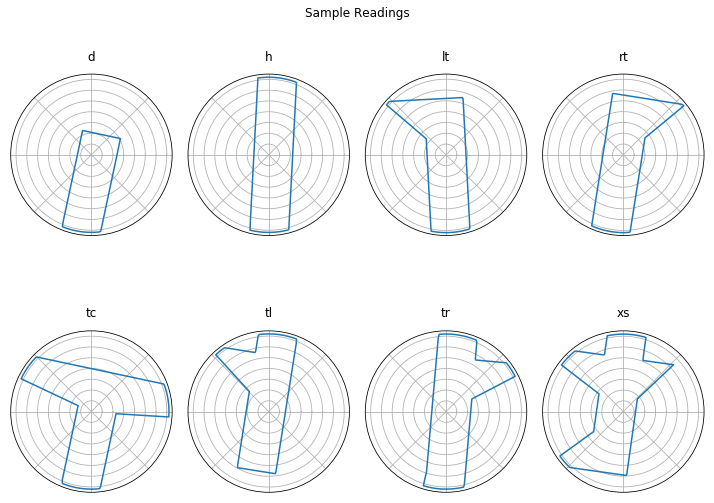

In [3]:
theta = np.arange(3*np.pi/2, -np.pi/2, -np.pi/180)
fig = plt.figure(figsize=(10,8))
choice = [0,1,2,3,4,5,6,7]
i = 0
while i < len(choice):
    ax = plt.subplot(2,4,i+1,projection='polar')
    ax.plot(theta,df_train_dirty.iloc[choice[i]][:-1])
    ax.set_title(df_train_dirty.iloc[choice[i]][-1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    i += 1
plt.suptitle('Sample Readings')
plt.tight_layout()
plt.show()

From here, without any preprocessing or effort, we could make a (slow) support vector classifier with 75% accuracy. It is matched in accuracy by the decision tree classifier. However, we can do better if, first, we establish methods of cleaning the data, starting with a very obvious abuse of the structure of the maze. We know that the we are in a grid, so we can easily "align" data to the grid, to get rid of some noise.

In [4]:
from math import cos, acos, pi, sqrt
from collections import Counter

good = [-2*pi,-3*pi/2,-pi,-pi/2,0,pi/2,pi,3*pi/2,2*pi]
def grid_clean(x):
    i = 0
    gamma = pi/180
    cg = cos(gamma)
    offs = Counter()
    while i < len(x)-2:
        a = x[i]
        b = x[i+1]
        if a<179 and b<179:
            beta = acos((a-b*cg)/sqrt(a*a+b*b-2*a*b*cg))
            theta = (i/180+1)*pi - beta
            j = 0
            d = float('inf')
            while j < len(good):
                nd = abs(good[j]-theta)
                if nd < d:
                    d = nd
                    off = good[j]-theta
                j += 1
            offs[int(off*180/pi)] += 1#sqrt((a*a+b*b-2*a*b*cg))
        i += 1
    best = max(offs,key = lambda thing : offs[thing])
    T = list(x)
    T = [T[int((i-best)%(len(T)-1))] for i in range(len(T)-1)]+[T[-1]]
    return T

Let's clean our training data and see how it looks.

In [5]:
df_train_clean = pd.DataFrame([grid_clean(df_train_dirty.iloc[i].values) for i in range(len(df_train_dirty))],
                             columns = [i for i in range(360)]+['Label'])

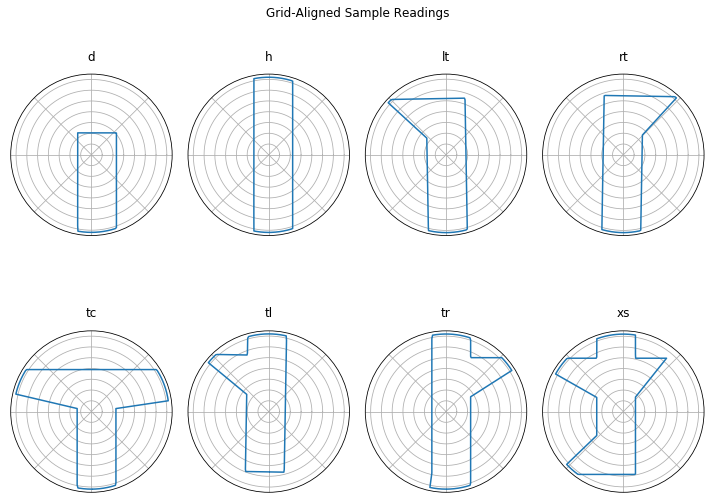

In [6]:
fig = plt.figure(figsize=(10,8))
i = 0
while i < len(choice):
    ax = plt.subplot(2,4,i+1,projection='polar')
    ax.plot(theta,df_train_clean.iloc[choice[i]][:-1])
    ax.set_title(df_train_clean.iloc[choice[i]][-1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    i += 1
plt.suptitle('Grid-Aligned Sample Readings')
plt.tight_layout()
plt.show()

Next, we'll add some pertinent data: discontinuities. We'll cound the number of discontinuties in the two quadrants in front of the simulator (and simultaneously drop all data pertaining to what's behind; the data behind us may actually help here, because we are only using three variations of each intersecion (i.e. 3 "backgrounds"), but the gain would be fake.

In [7]:
def add_disc_count(x):#count discontinuities in "front" quadrants (i.e. 90 to 180 and 180 to 270)
    i = 90
    dc1 = 0
    dc2 = 0
    while i < 180:
        if abs(x[i]-x[i+1]) > 20:
            dc1 += 1
        i += 1
    while i < 270:
        if abs(x[i]-x[i+1]) > 20:
            dc2 += 1
        i += 1
    return ([x[i] for i in range(90,271)])[::-1] + [dc1,dc2] + [x[-1]]

And we'll apply our discontinuty count, and display the new "front only" data.

In [8]:
df_train_clean = pd.DataFrame([add_disc_count(df_train_clean.iloc[i].values) for i in range(len(df_train_clean))],
                             columns = [i for i in range(181)]+['dc1','dc2','Label'])
df_train_clean.head(8)

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,dc1,dc2,Label
0,58.042780,58.051622,58.078160,58.122435,58.184515,58.264494,58.362496,58.478671,58.613200,58.766291,...,32.133249,32.079291,32.035256,32.001076,31.976699,31.962088,31.957220,0,0,d
1,55.506806,55.515261,55.540640,55.582981,55.642348,55.718833,55.812553,55.923652,56.052303,56.198705,...,34.683192,34.624952,34.577423,34.540531,34.514219,34.498448,34.493194,0,0,h
2,46.175775,46.168742,46.175775,46.196884,46.232101,46.281481,46.345099,46.423052,46.515461,46.622469,...,44.160423,44.072693,43.998686,43.938290,43.891410,43.857975,43.837935,1,0,lt
3,43.341136,43.360950,43.394005,43.440354,43.500066,43.573234,43.659970,43.760409,43.874706,44.003040,...,46.843719,46.779417,46.729506,46.693909,46.672573,46.665465,46.672573,0,1,rt
4,56.875425,56.884088,56.910093,56.953478,57.014309,57.092680,57.188710,57.302549,180.000000,180.000000,...,33.307035,33.251106,33.205462,33.170034,33.144766,33.129621,33.124575,1,1,tc
5,38.309521,38.327034,38.356252,38.397220,38.450000,38.514674,38.591340,38.680119,38.781147,38.894582,...,51.893785,51.822551,51.767259,51.727825,51.704188,51.696314,51.704188,1,0,tl
6,57.095993,57.104690,57.130796,57.174349,57.235416,57.314090,57.410494,57.524774,57.657108,57.807702,...,33.085251,33.029695,32.984355,32.949163,32.924063,32.909019,32.904007,0,1,tr
7,28.201957,28.206253,28.219148,28.240660,28.270823,28.309684,28.357301,28.413749,28.479114,28.553498,...,62.138444,62.034101,61.948947,61.882851,61.835711,61.807456,61.798043,1,1,xs


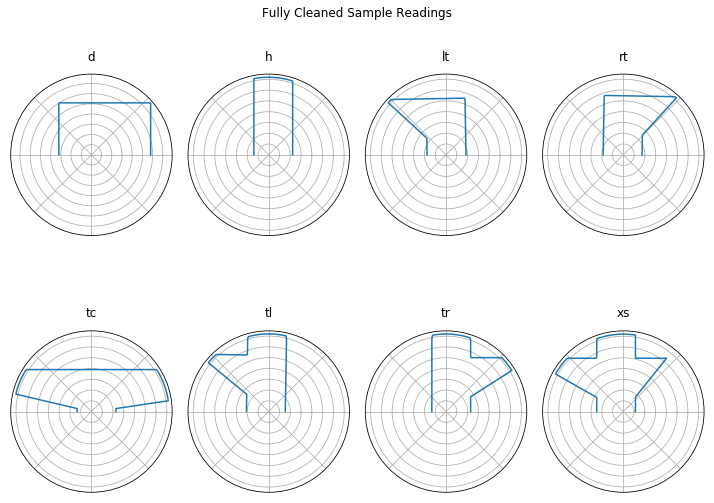

In [9]:
theta = np.arange(0,np.pi+np.pi/180,np.pi/180)
fig = plt.figure(figsize=(10,8))
i = 0
while i < len(choice):
    ax = plt.subplot(2,4,i+1,projection='polar')
    ax.plot(theta,df_train_clean.iloc[choice[i]][:-3])
    ax.set_title(df_train_clean.iloc[choice[i]][-1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    i += 1
plt.suptitle('Fully Cleaned Sample Readings')
plt.tight_layout()
plt.show()

Now that we've cleaned up the training data, we can do some work. We'll start with forward stepwise selection on the decision tree classifier.

In [10]:
import statsmodels.api as sm
import sklearn
import sklearn.tree

x = df_train_clean.drop(['Label'],axis=1)
y = df_train_clean.Label

predictors = list(x)
n = y.size
tree = sklearn.tree.DecisionTreeClassifier(max_leaf_nodes=25, criterion='entropy')
kf = sklearn.model_selection.KFold(n_splits=10,shuffle=True,random_state=1)

tree_nodes = list()
tree_errors = list()
best = (float('inf'),'')
it = len(predictors)
for pred in predictors:
    X = sm.add_constant(x[pred]).values.reshape(-1,2)
    error = 1-sklearn.model_selection.cross_val_score(tree,X,y,cv=kf,scoring='accuracy').mean()
    if error < best[0]:
        best = (error,pred)
tree_errors.append(best[0])
tree_nodes.append(best[1])
predictors.remove(best[1])
i = 1
while i < 26:
    best = (float('inf'),'')
    for pred in predictors:
        X = sm.add_constant(x[tree_nodes+[pred]]).values.reshape(-1,i+2)
        error = 1-sklearn.model_selection.cross_val_score(tree,X,y,cv=kf,scoring='accuracy').mean()
        if error < best[0]:
            best = (error,pred)
    tree_errors.append(best[0])
    tree_nodes.append(best[1])
    predictors.remove(best[1])
    if i%5 == 0:
        print(i,'/',25)
    i += 1

5 / 25
10 / 25
15 / 25
20 / 25
25 / 25


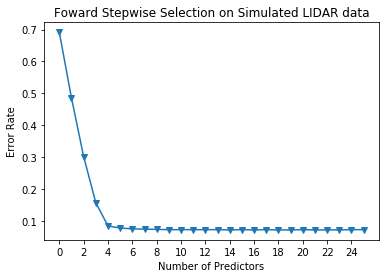

The best error rate, 0.0717, results from using 15 predictors.


In [11]:
fig , ax = plt.subplots()
ax.plot(np.arange(0,26),tree_errors, '-v')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('Error Rate')
ax.set_title('Foward Stepwise Selection on Simulated LIDAR data')
ax.set_xticks(np.arange(0, 26, 2))
plt.show()
best = min(tree_errors)
best_index = tree_errors.index(best)
print('The best error rate, '+str(np.round(best,decimals=4))+', results from using',best_index+1,'predictors.')

In [12]:
file = open('data/tree_fss.dat','w')
file.write(str(tree_nodes[:best_index+1]))
file.close()

In [13]:
tree_pred = tree_nodes[:best_index+1]
x_tree = x[tree_pred]

max_leaf_nodes = [5*i for i in range(1,50)]
tuning = [{'max_leaf_nodes':max_leaf_nodes}]
print('Trying max_leaf_node values in ',max_leaf_nodes)
clf = sklearn.model_selection.GridSearchCV(sklearn.tree.DecisionTreeClassifier(criterion='entropy'),
                                           tuning,cv=10,
                                           scoring='accuracy')
clf.fit(x_tree,y)
print('Best value:',clf.best_params_)

'''C = np.concatenate((np.arange(0.001,0.01,0.001),np.arange(0.01,0.11,0.01)))
tuning = [{'C':C}]
print('Trying C values in',C)
clf = sklearn.model_selection.GridSearchCV(sklearn.svm.SVC(kernel='linear'),
                                           tuning,cv=10,scoring='accuracy')
clf.fit(x,y)
print('Best value:',clf.best_params_)'''

tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=clf.best_params_['max_leaf_nodes'])
#svc = sklearn.svm.SVC(kernel='linear',C=clf.best_params_['C'])
acc = sklearn.model_selection.cross_val_score(tree,
                                        x,y,cv=10,scoring='accuracy').mean()
print('Mean accuracy from 10-fold cross validation with max_leaf_nodes='+str(clf.best_params_['max_leaf_nodes'])+':',
                                                                round(acc,3))

Trying max_leaf_node values in  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245]
Best value: {'max_leaf_nodes': 95}
Mean accuracy from 10-fold cross validation with max_leaf_nodes=95: 0.907


89%! And that's a decision tree classifier---i.e. it's fast. We can easily compute several (hundred) of these per second, and with even 70 percent accuracy that would be more than enough to get a strong classification assuming that the robot is in motion. Let's fit a model and see exactly how quickly we can process raw "dirty" test data.

In [14]:
tree.fit(x_tree,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=95, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [15]:
df_test_dirty = pd.read_csv('data/df_test_dirty.csv').drop(['Unnamed: 0'],axis=1)

In [16]:
from datetime import datetime

startTime = datetime.now()
df_test_clean = pd.DataFrame([grid_clean(df_test_dirty.iloc[i].values) for i in range(len(df_test_dirty))],
                             columns = [i for i in range(360)]+['Label'])
df_test_clean = pd.DataFrame([add_disc_count(df_test_clean.iloc[i].values) for i in range(len(df_test_clean))],
                             columns = [i for i in range(181)]+['dc1','dc2','Label'])
x_tree_test = df_test_clean[tree_pred]
y_test = df_test_clean.Label
p = tree.predict(x_tree_test)

elapsed = datetime.now() - startTime
n = len(y_test)
print('number of predictions:',n)
print('accuracy:',sklearn.metrics.accuracy_score(p,y_test))
print('elapsed time:',elapsed)
print('time per prediction:',elapsed/n)
labels = y_test.unique()
correct = Counter()
total = Counter()
i = 0
while i < len(y_test):
    if p[i] == y_test[i]:
        correct[y_test[i]] += 1
    total[y_test[i]] += 1
    i += 1

for label in total:
    print(label.rjust(5),':',correct[label],'/',total[label],' = ',round(correct[label]/total[label],4))

number of predictions: 1200
accuracy: 0.91
elapsed time: 0:00:04.037315
time per prediction: 0:00:00.003364
   xs : 129 / 150  =  0.86
   rt : 147 / 150  =  0.98
   tc : 124 / 150  =  0.8267
   tr : 136 / 150  =  0.9067
    d : 142 / 150  =  0.9467
   tl : 141 / 150  =  0.94
   lt : 146 / 150  =  0.9733
    h : 127 / 150  =  0.8467


So we've built a very effective classifier here, given that we can simply continuously classify a few hundred frames per second to establish with certainty what's ahead! Finally, let's see what the first few decisions in out tree look like:

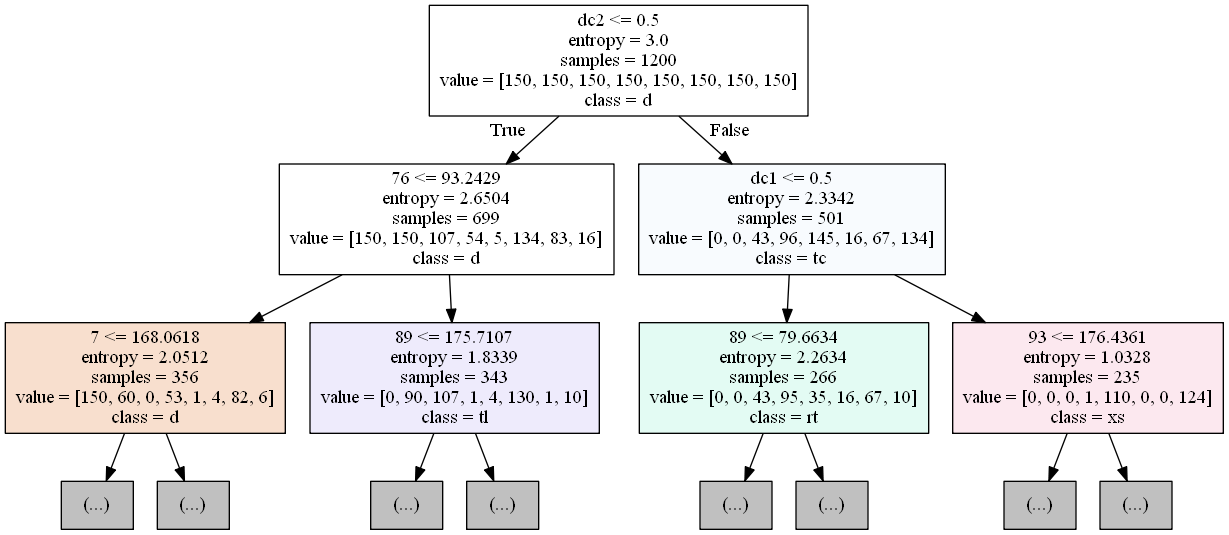

In [17]:
import pydotplus
import IPython.display

def print_tree(estimator, features, class_names=cfgs, filled=True):
    classn = class_names
    
    dot_data = sklearn.externals.six.StringIO()
    sklearn.tree.export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled,
                                max_depth=2)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

graph = print_tree(tree, features=tree_pred)
IPython.display.Image(graph.create_png())

So the first few splits are made primarily based on the number of disconnects and angles "near 90" (during the process of cleaning the data, 90 degrees became "forward"). Note that a split "85 <= 177.6179" means "if the distance measure at angle 85 is less than 177.6179". Also note that "dc1" and "dc2" are the number of discontinuties quadrants 2 and 1 respectively (where angle pi/2 is "forward", so quadrant 1 is "right" and quadrant 2 is "left").

Given even 10-20 unique samples per second, this classifier should perform perfectly if we add an extra layer which keeps the "most common" of the last 20, 100, or some other benchmark (last .25 seconds worth of inputs, for instance). As long as we don't move too fast, so we have .25 seconds to react, we're set!

Anyway, our model isn't going to get much better, so that concludes our analysis here.